In [1]:
!nvidia-smi

Fri Apr  7 17:03:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.05    Driver Version: 522.25       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   46C    P8    26W / 350W |    395MiB / 24576MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau

# metric
from sklearn.metrics import fbeta_score

import wandb

# config

In [3]:
BASE_DIR = "/working/"
INPUT_DIR = os.path.join(BASE_DIR, "input")
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR, "test")
SURFACE_NUM = 5

OUTPUT_DIR = os.path.join(BASE_DIR, "output")

CFG = {
    "DEBUG" : False,
    # exp setting
    "EXP_CATEGORY" : "makebase",
    "EXP_NAME" : "base000",
    "folds" : ["0"],

    # model
    "model_name" : "tf_efficientnet_b0",
    "inp_channels" : SURFACE_NUM + 1,
    "out_channels" : 1,
    "pretrained" : True,
    "out_indices" : [0,1,2,3,4],
 
    # data   
    "img_size": [256, 256],
    "batch_size": 16,
    "INPUT_DIR": INPUT_DIR,
    "TRAIN_DIR": TRAIN_DIR,
    "TEST_DIR": TEST_DIR,
    "OUTPUT_DIR": OUTPUT_DIR,
    "surface_num": SURFACE_NUM,
    # "TRAIN_IDX_LIST": ["1", "2"],
    "TRAIN_IDX_LIST" : ["1"],
    "VALID_IDX_LIST": ["3"],
    "TEST_IDX_LIST": ["a", "b"],

    # learning
    "n_epoch" : 15,
    "lr" : 1e-5,
    "T_max" : 10,
    "min_lr" : 1e-8,
    "weight_decay" : 1e-6,

    # etc
    "print_freq" : 1000,
    "random_seed" : 21,
    "num_workers": 2,
}

if CFG["DEBUG"]:
    CFG["n_epoch"] = 1
    CFG["EXP_NAME"] = "DEBUG"

In [4]:
# if not CFG["DEBUG"]:
#     exp_path = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"])
#     print(exp_path)
#     os.makedirs(exp_path)

In [5]:
# if not CFG["DEBUG"]:
#     os.environ["WANDB_SILENT"] = "true"
#     WANDB_CONFIG = {'competition': 'VCID', '_wandb_kernel': 'taro'}

#     wandb.init(project=WANDB_CONFIG["competition"], config=CFG, group=CFG["EXP_CATEGORY"], name=CFG["EXP_NAME"])

# utils

In [6]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [8]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

# model

In [9]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        channel_nums = [320, 112, 40, 24, 16, 8]
        self.UpConv_0 = UpConv(channel_nums[0], channel_nums[1])
        self.UpConv_1 = UpConv(channel_nums[1]*2, channel_nums[2])
        self.UpConv_2 = UpConv(channel_nums[2]*2, channel_nums[3])
        self.UpConv_3 = UpConv(channel_nums[3]*2, channel_nums[4])
        self.UpConv_4 = UpConv(channel_nums[4]*2, channel_nums[5])
    
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
        emb = self.UpConv_3(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)

        emb_cat = self.UpConv_4(emb_cat)
        
        return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder()
        self.head = nn.Sequential(
            # nn.Conv2d(32, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
            nn.Conv2d(8, CFG["out_channels"], kernel_size=1, stride=1, padding="same"),
            nn.Sigmoid()
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        emb = self.decoder(skip_connection_list)
        output = self.head(emb)
        return output

# Dataset

In [10]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ToFloat(max_value=255),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.ToFloat(max_value=255),
    ToTensorV2(),
])


In [11]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, mode="train", transform=None):
        # get config
        self.mode = mode
        if self.mode=="train":
            self.DATADIR = CFG["TRAIN_DIR"]
            self.data_idx_list = CFG["TRAIN_IDX_LIST"]
        elif self.mode=="valid":
            self.DATADIR = CFG["TRAIN_DIR"]
            self.data_idx_list = CFG["VALID_IDX_LIST"]
        elif self.mode == "test":
            self.DATADIR = CFG["TEST_DIR"]
            self.data_idx_list = CFG["TEST_IDX_LIST"]
        self.surface_num = CFG["surface_num"]
        self.img_size = CFG["img_size"]
        self.transform = transform
        
        # get imgs
        print("initializing dataset...")
        self.imgs = []
        for idx in self.data_idx_list:
            img_path = os.path.join(self.DATADIR, idx, "mask.png")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            self.imgs.append(img)
        
        # check imgs
        for img in self.imgs:
            assert img is not None, "img is None. data path is wrong"
        # get and split surface
        self.surface_vols = self.read_surfacevols()
        for surface_vol in self.surface_vols:
            assert surface_vol is not None, "surface_vol is None. data path is wrong"
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for idx in self.data_idx_list:
                label_path = os.path.join(self.DATADIR, idx, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        print("initializing dataset done.")

    def read_surfacevols(self):
        surface_vols = []
        print("reading surface volume...")
        for img_idx in self.data_idx_list:
            surface_vol_ = None
            for i in range(self.surface_num):
                print("\r", f"reading idx : {i+1}/{self.surface_num}", end="")
                surface_path = os.path.join(self.DATADIR, img_idx, "surface_volume", f"{i:02}.tif")
                surface_vol = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            print(f"  => read surface volume done. [{img_idx}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        img_grid = img[grid_idx[0]*self.img_size[0]:(grid_idx[0]+1)*self.img_size[0],
                        grid_idx[1]*self.img_size[1]:(grid_idx[1]+1)*self.img_size[1]]
        return img_grid 

    def get_all_grid(self):
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = img.shape[0] // self.img_size[0]
            self.y_grid_size = img.shape[1] // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        img_grid_idx = self.flatten_grid[idx]
        img_idx = img_grid_idx[0]
        grid_idx = img_grid_idx[1:]
        # get img & surface_vol
        img = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        img = self.get_grid_img(img, grid_idx)
        surface_vol = self.get_grid_img(surface_vol, grid_idx)
        assert surface_vol.shape[0]==img.shape[0] and surface_vol.shape[1]==img.shape[1] , "surface_vol_list shape is not same as img shape"
        
        # concat img & surface_vol in channel axix 
        img = np.concatenate([img, surface_vol], axis=2)
        # img = np.concatenate([img*255, surface_vol], axis=2)

        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img, grid_idx
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1)/255. # (channel, h, w)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1)/255. # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            return img, label, grid_idx


In [12]:
# transforms = A.Compose([
#     A.HorizontalFlip(p=1.0),
#     # A.VerticalFlip(p=0.5),
#     # A.RandomRotate90(p=0.5),
#     A.ToFloat(max_value=255),
#     ToTensorV2(),
# ])

# print("dataset")
# dataset = VCID_Dataset(CFG, mode="train", transform=transforms)
# print("dataloader")
# dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)


# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, mode="train")
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)


In [13]:
# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader):
#     img = imgs[0].permute(1, 2, 0)
#     label = labels[0].permute(1, 2, 0)
#     if batch_idx < imshow_batch:
#         pass
#     else:
#         print("batch_idx: ", batch_idx)
#         print(imgs.shape)
#         print(labels.shape)
#         print(img.shape)
#         print(label.shape)
#         plt.figure(figsize=(20, 20))
#         for idx in range(CFG["surface_num"]+1):
#             plt.subplot(1, CFG["surface_num"]+2, idx+1)
#             plt.imshow(img[:,:,idx])
#         plt.subplot(1, CFG["surface_num"]+2, 2+CFG["surface_num"])
#         plt.imshow(label)
#         plt.show()
#         break

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     label = labels[0].permute(1, 2, 0)
#     if batch_idx < imshow_batch:
#         pass
#     else:
#         print("batch_idx: ", batch_idx)
#         print(imgs.shape)
#         print(labels.shape)
#         print(img.shape)
#         print(label.shape)
#         plt.figure(figsize=(20, 20))
#         for idx in range(CFG["surface_num"]+1):
#             plt.subplot(1, CFG["surface_num"]+2, idx+1)
#             plt.imshow(img[:,:,idx])
#         plt.subplot(1, CFG["surface_num"]+2, 2+CFG["surface_num"])
#         plt.imshow(label)
#         plt.show()
#         break


In [14]:

# plt.figure(figsize=(20, 20))
# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     plt.subplot(1, imshow_batch+1, batch_idx+1)
#     plt.imshow(img[:,:,0])
#     if batch_idx >= imshow_batch:
#         break    
# plt.show()


# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten(), bins=np.arange(255))
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])

# train valid fn

In [15]:
def train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler):
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, _) in enumerate(train_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()     
        preds = model(images)
        
        # preds = torch.sigmoid(preds)
        loss = criterion(preds, targets)
        
        losses.update(loss.item(), CFG["batch_size"]) 
        targets = targets.detach().cpu().numpy().ravel().tolist()
        # preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()
        preds = preds.detach().cpu().numpy().ravel().tolist()
        loss.backward() # パラメータの勾配を計算
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
                
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(train_loader)-1):
            print('\t Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                        epoch, batch_idx, len(train_loader), batch_time=batch_time, loss=losses,
                        remain=timeSince(start, float(batch_idx+1)/len(train_loader)),
            ))
        del preds, images, targets
    gc.collect()
    torch.cuda.empty_cache()
    return losses.avg

In [16]:
def valid_fn(model, valid_loader, criterion):
    model.eval()# モデルを検証モードに設定
    test_targets = []
    test_preds = []
    test_grid_idx = []
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, grid_idx) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()
        with torch.no_grad():
            preds = model(images)
            # preds = torch.sigmoid(preds)
            loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)
        # targets = targets.detach().cpu().numpy().ravel().tolist()
        # preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()
        # preds = preds.detach().cpu().numpy().ravel().tolist()
        targets = targets.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()
        
        # test_preds.append(preds)
        # test_targets.append(targets)
        test_preds.extend([preds[idx, :,:,:].transpose(1,2,0) for idx in range(preds.shape[0])])
        test_targets.extend([targets[idx, :,:,:].transpose(1,2,0) for idx in range(targets.shape[0])])
        test_grid_idx.extend([[x_idx, y_idx] for x_idx, y_idx in zip(grid_idx[0].tolist(), grid_idx[1].tolist())])
        # test_preds.extend(preds.flatten())
        # test_targets.extend(targets.flatten())
        # score = matthews_corrcoef(preds, targets)
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1):
            print('\t EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del preds, images, targets
        gc.collect()
        torch.cuda.empty_cache()
    # test_preds = np.ndarray(test_preds)
    # test_targets = np.ndarray(test_targets)
    # print(test_preds.shape, test_targets.shape)
    return test_targets, test_preds, test_grid_idx, losses.avg

# training loop

In [17]:
def concat_grid_img(img_list, label_list, grid_idx_list):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], CFG["VALID_IDX_LIST"][0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        pred_img[grid_idx[0]*CFG["img_size"][0]:(grid_idx[0]+1)*CFG["img_size"][0],
                grid_idx[1]*CFG["img_size"][1]:(grid_idx[1]+1)*CFG["img_size"][1], :] += img_list[img_idx]
        
        label_img[grid_idx[0]*CFG["img_size"][0]:(grid_idx[0]+1)*CFG["img_size"][0],
                grid_idx[1]*CFG["img_size"][1]:(grid_idx[1]+1)*CFG["img_size"][1], :] += label_list[img_idx]
    return pred_img, label_img

In [18]:
def training_loop(CFG):
    # set model & learning fn
    model = SegModel(CFG)
    model = model.to(device)
    # if not CFG["DEBUG"]:
    #     wandb.watch(model)
    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCELoss()
    optimizer = AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)
    for fold in CFG["folds"]:
        # separate train/valid data 
        train_dataset = VCID_Dataset(CFG, mode="train", transform=train_transforms)
        valid_dataset = VCID_Dataset(CFG, mode="valid", transform=valid_transforms)
        train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle = True,
                                    num_workers = CFG["num_workers"], pin_memory = True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = False,
                                    num_workers = CFG["num_workers"], pin_memory = True)

        # training
        best_score = -np.inf
        start_time = time.time()
        for epoch in range(1, CFG["n_epoch"] + 1):
            print(f'\t === epoch: {epoch}: training ===')
            train_loss_avg = train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler)
            valid_targets, valid_preds, valid_grid_idx, valid_loss_avg = valid_fn(model, valid_loader, criterion)
            
            # target, predをconcatして元のサイズに戻す
            valid_preds_img, valid_targets_img  = concat_grid_img(valid_preds, valid_targets, valid_grid_idx)
            print("valid_preds shape = ", valid_preds_img.shape)
            print("valid_targets shape = ", valid_targets_img.shape)

            plt.figure(dpi=20)
            plt.subplot(1,2,1)
            plt.imshow(valid_preds_img)
            plt.subplot(1,2,2)
            plt.imshow(valid_targets_img)
            plt.show()
            #  plot hisgram
            # plt.figure(dpi=100)
            # plt.subplot(1,2,1)
            # plt.hist(valid_preds_img.flatten(), bins=100)
            # plt.subplot(1,2,2)
            # plt.hist(valid_targets_img.flatten(), bins=100)
            # plt.show()

            valid_score, valid_threshold = calc_cv(valid_targets_img, valid_preds_img)

            elapsed = time.time() - start_time
            print(f'\t epoch:{epoch}, avg train loss:{train_loss_avg:.4f}, avg valid loss:{valid_loss_avg:.4f}, score:{valid_score:.4f}(th={valid_threshold}) ::: time:{elapsed:.2f}s')
            scheduler.step()
            # validationスコアがbestを更新したらモデルを保存する
            if valid_score > best_score:
                best_score = valid_score
                model_name = CFG["model_name"]
                model_path = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"], f'{model_name}_segmodel_fold{fold}.pth')
                torch.save(model.state_dict(), model_path) 
                print(f'\t Epoch {epoch} - Save Best Score: {best_score:.4f}. Model is saved.')

    # del train_loader, train_dataset, valid_loader, valid_dataset
    gc.collect()
    torch.cuda.empty_cache()

# main

initializing dataset...
reading surface volume...
 reading idx : 5/5  => read surface volume done. [1]
split grid done.
initializing dataset done.
initializing dataset...
reading surface volume...
 reading idx : 5/5  => read surface volume done. [3]
split grid done.
initializing dataset done.
	 === epoch: 1: training ===


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


	 Epoch: [1][0/31] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7174(0.7174) 
	 Epoch: [1][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.7044(0.7067) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 3s) Loss: 0.6053(0.6053) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6020(0.6517) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


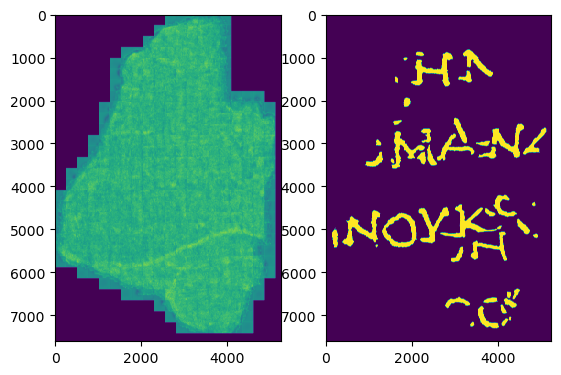

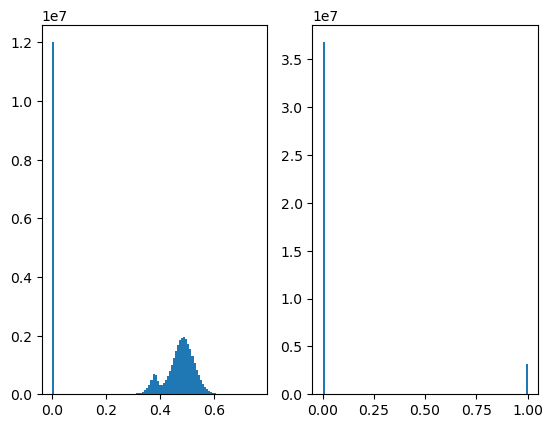

th: 0.1, fbeta: 0.13807337487286492
th: 0.15, fbeta: 0.13807342777237602
th: 0.2, fbeta: 0.1380760968457789
th: 0.25, fbeta: 0.13809480099779894
th: 0.3, fbeta: 0.13827616669134807
th: 0.35, fbeta: 0.13988056322211873
th: 0.4, fbeta: 0.15564282364992466
th: 0.45, fbeta: 0.16114115249957092
th: 0.5, fbeta: 0.147293423068101
	 epoch:1, avg train loss:0.7067, avg valid loss:0.6517, score:0.1611(th=0.45) ::: time:11.68s
	 Epoch 1 - Save Best Score: 0.1611. Model is saved.
	 === epoch: 2: training ===
	 Epoch: [2][0/31] Elapsed 0m 0s (remain 0m 13s) Loss: 0.6918(0.6918) 
	 Epoch: [2][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6935(0.6918) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.6389(0.6389) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6015(0.6883) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


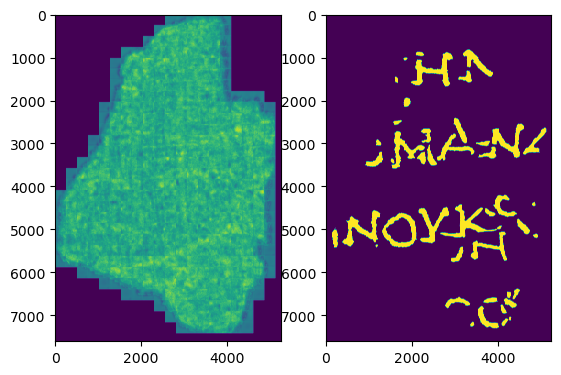

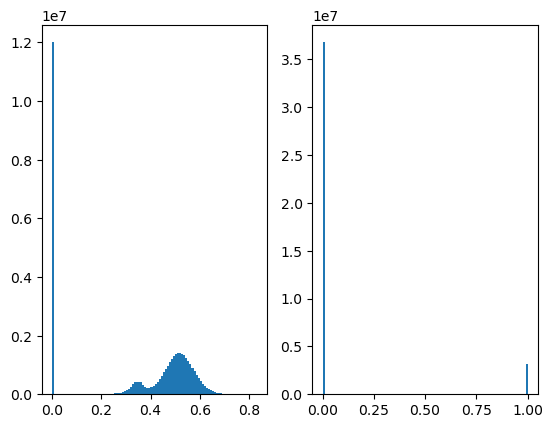

th: 0.1, fbeta: 0.1380738124973123
th: 0.15, fbeta: 0.1380825078526645
th: 0.2, fbeta: 0.1381221887792701
th: 0.25, fbeta: 0.13843354913668451
th: 0.3, fbeta: 0.1401513428852493
th: 0.35, fbeta: 0.14891770675897453
th: 0.4, fbeta: 0.15776394391983445
th: 0.45, fbeta: 0.15875127156656993
th: 0.5, fbeta: 0.15433800649947815
	 epoch:2, avg train loss:0.6918, avg valid loss:0.6883, score:0.1588(th=0.45) ::: time:22.95s
	 === epoch: 3: training ===
	 Epoch: [3][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.6885(0.6885) 
	 Epoch: [3][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6745(0.6833) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.6227(0.6227) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6244(0.6822) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


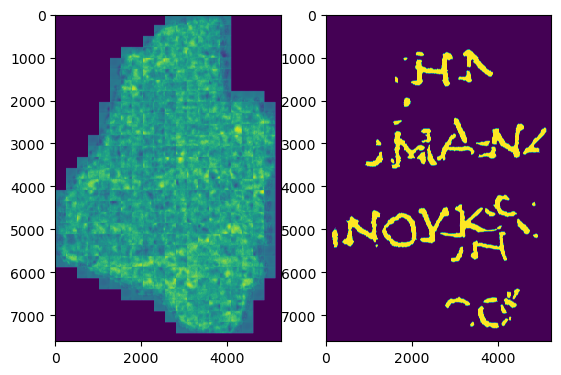

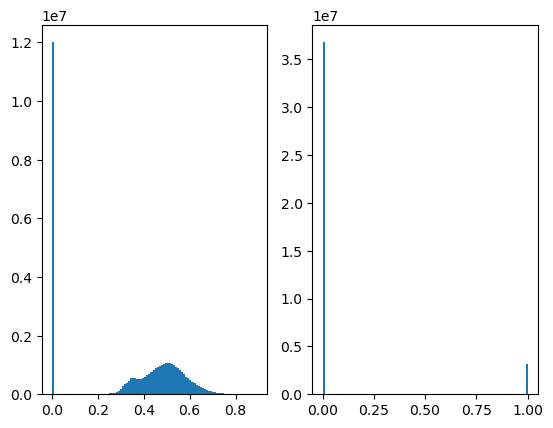

th: 0.1, fbeta: 0.13807365860708048
th: 0.15, fbeta: 0.1380884417483624
th: 0.2, fbeta: 0.13817000589757691
th: 0.25, fbeta: 0.13846409003290017
th: 0.3, fbeta: 0.13986480504532947
th: 0.35, fbeta: 0.14855493179566687
th: 0.4, fbeta: 0.15501039948333076
th: 0.45, fbeta: 0.15240271705950295
th: 0.5, fbeta: 0.146523701323686
	 epoch:3, avg train loss:0.6833, avg valid loss:0.6822, score:0.1550(th=0.4) ::: time:34.48s
	 === epoch: 4: training ===
	 Epoch: [4][0/31] Elapsed 0m 0s (remain 0m 11s) Loss: 0.6649(0.6649) 
	 Epoch: [4][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6634(0.6730) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.6047(0.6047) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5855(0.6509) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


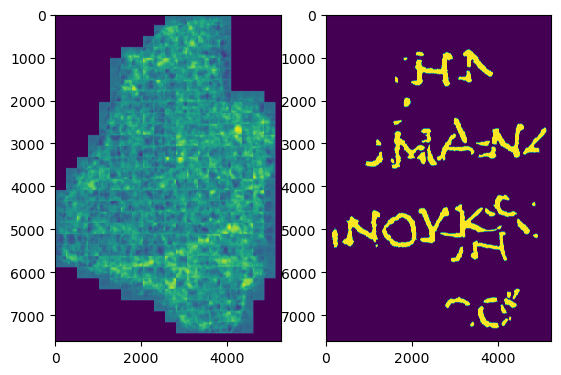

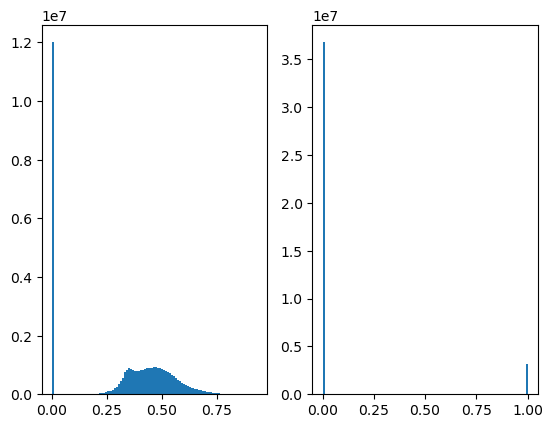

th: 0.1, fbeta: 0.13807367303427515
th: 0.15, fbeta: 0.13807800329495507
th: 0.2, fbeta: 0.13795073952663375
th: 0.25, fbeta: 0.13787205094557442
th: 0.3, fbeta: 0.13788969982940782
th: 0.35, fbeta: 0.1427492332359108
th: 0.4, fbeta: 0.14741628091564057
th: 0.45, fbeta: 0.14555118643730758
th: 0.5, fbeta: 0.1393776008838993
	 epoch:4, avg train loss:0.6730, avg valid loss:0.6509, score:0.1474(th=0.4) ::: time:46.06s
	 === epoch: 5: training ===
	 Epoch: [5][0/31] Elapsed 0m 0s (remain 0m 12s) Loss: 0.6265(0.6265) 
	 Epoch: [5][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6651(0.6555) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.6133(0.6133) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6157(0.6972) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


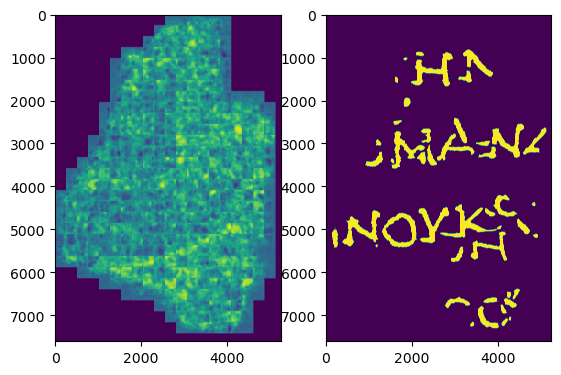

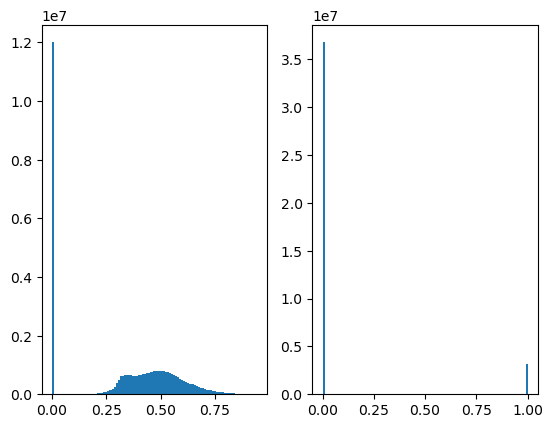

th: 0.1, fbeta: 0.13807658738941322
th: 0.15, fbeta: 0.1381084309925708
th: 0.2, fbeta: 0.13799060260164847
th: 0.25, fbeta: 0.13783095542501936
th: 0.3, fbeta: 0.1382951297085799
th: 0.35, fbeta: 0.1452201413713695
th: 0.4, fbeta: 0.14806205691541088
th: 0.45, fbeta: 0.1449931569542587
th: 0.5, fbeta: 0.13775309424705953
	 epoch:5, avg train loss:0.6555, avg valid loss:0.6972, score:0.1481(th=0.4) ::: time:57.53s
	 === epoch: 6: training ===
	 Epoch: [6][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.6891(0.6891) 
	 Epoch: [6][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5943(0.6453) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.6010(0.6010) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6464(0.6946) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


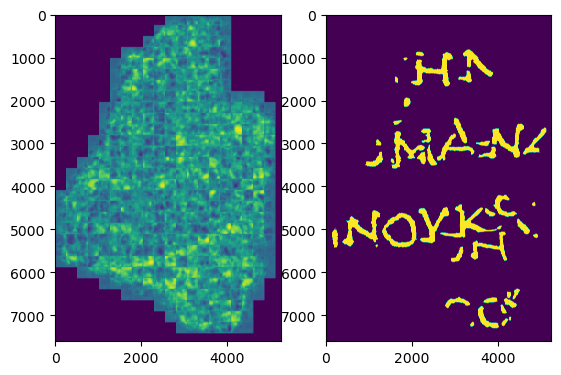

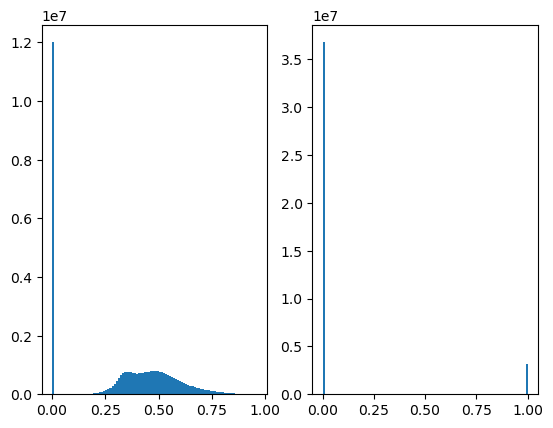

th: 0.1, fbeta: 0.13807363456176278
th: 0.15, fbeta: 0.1380837653905204
th: 0.2, fbeta: 0.13783706368893373
th: 0.25, fbeta: 0.13732807594500954
th: 0.3, fbeta: 0.1365440075154735
th: 0.35, fbeta: 0.1412215029440554
th: 0.4, fbeta: 0.14370106885129205
th: 0.45, fbeta: 0.1386630935030748
th: 0.5, fbeta: 0.1291095400971389
	 epoch:6, avg train loss:0.6453, avg valid loss:0.6946, score:0.1437(th=0.4) ::: time:68.99s
	 === epoch: 7: training ===
	 Epoch: [7][0/31] Elapsed 0m 0s (remain 0m 13s) Loss: 0.5752(0.5752) 
	 Epoch: [7][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5763(0.6342) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5433(0.5433) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6062(0.6535) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


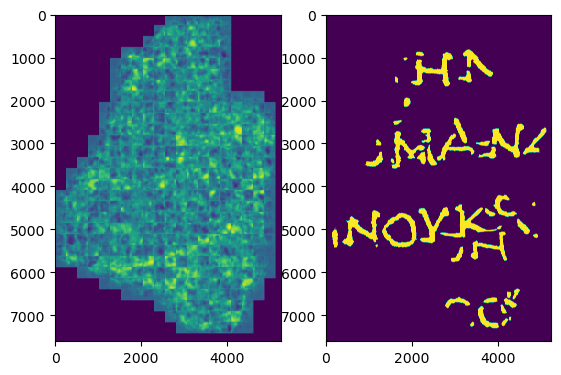

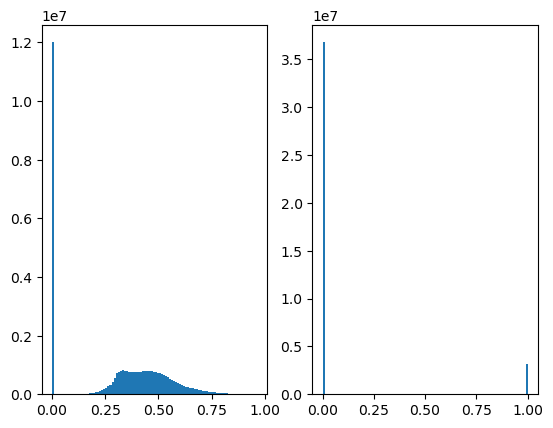

th: 0.1, fbeta: 0.13808424897908136
th: 0.15, fbeta: 0.13804193401395243
th: 0.2, fbeta: 0.13760611479428425
th: 0.25, fbeta: 0.13687931300381156
th: 0.3, fbeta: 0.13669271080761733
th: 0.35, fbeta: 0.14265363320669755
th: 0.4, fbeta: 0.14338587725458263
th: 0.45, fbeta: 0.13658592531393116
th: 0.5, fbeta: 0.1257606628363349
	 epoch:7, avg train loss:0.6342, avg valid loss:0.6535, score:0.1434(th=0.4) ::: time:80.43s
	 === epoch: 8: training ===
	 Epoch: [8][0/31] Elapsed 0m 0s (remain 0m 12s) Loss: 0.6325(0.6325) 
	 Epoch: [8][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6168(0.6215) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5481(0.5481) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6021(0.6458) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


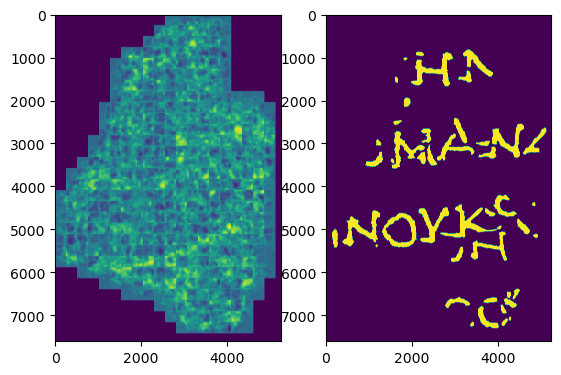

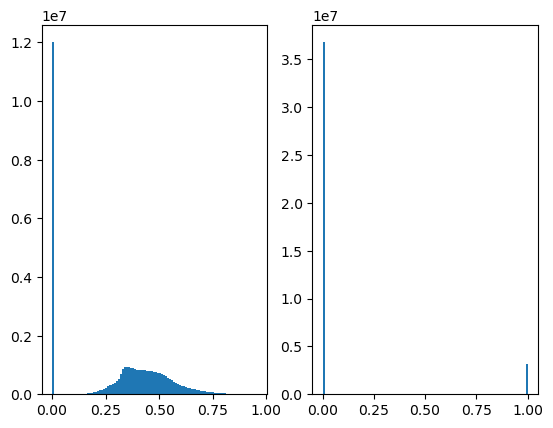

th: 0.1, fbeta: 0.1380941578824809
th: 0.15, fbeta: 0.13810125490235994
th: 0.2, fbeta: 0.13761155880422268
th: 0.25, fbeta: 0.13630134377073047
th: 0.3, fbeta: 0.13364616502381643
th: 0.35, fbeta: 0.13646513070523839
th: 0.4, fbeta: 0.13925233253169045
th: 0.45, fbeta: 0.1325614375241429
th: 0.5, fbeta: 0.12252381914622093
	 epoch:8, avg train loss:0.6215, avg valid loss:0.6458, score:0.1393(th=0.4) ::: time:91.87s
	 === epoch: 9: training ===
	 Epoch: [9][0/31] Elapsed 0m 0s (remain 0m 15s) Loss: 0.6988(0.6988) 
	 Epoch: [9][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5723(0.6222) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5362(0.5362) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5978(0.6331) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


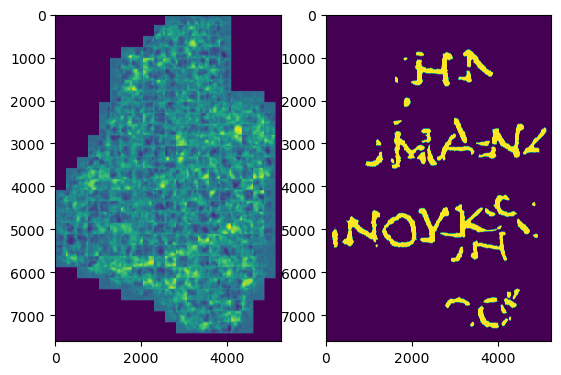

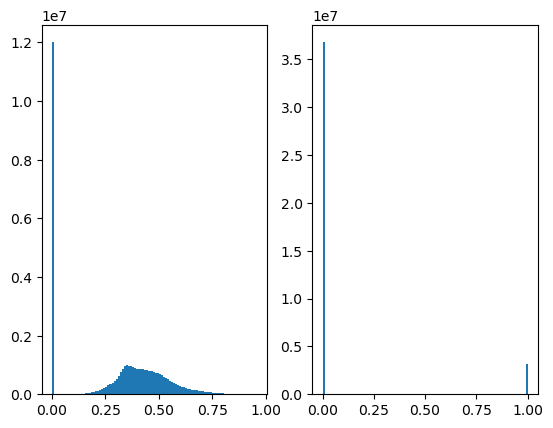

th: 0.1, fbeta: 0.13808331107403643
th: 0.15, fbeta: 0.13785970763185648
th: 0.2, fbeta: 0.1371879062803234
th: 0.25, fbeta: 0.13571847802138565
th: 0.3, fbeta: 0.13299649551314416
th: 0.35, fbeta: 0.13531911172306166
th: 0.4, fbeta: 0.13672587830243632
th: 0.45, fbeta: 0.13200593001839098
th: 0.5, fbeta: 0.12230163502032788
	 epoch:9, avg train loss:0.6222, avg valid loss:0.6331, score:0.1381(th=0.1) ::: time:103.58s
	 === epoch: 10: training ===
	 Epoch: [10][0/31] Elapsed 0m 0s (remain 0m 13s) Loss: 0.6013(0.6013) 
	 Epoch: [10][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6191(0.6272) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5432(0.5432) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6133(0.6405) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


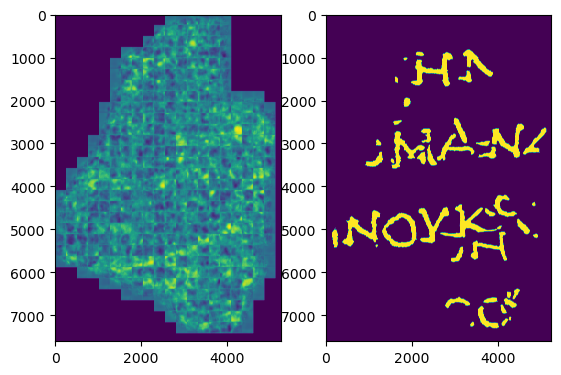

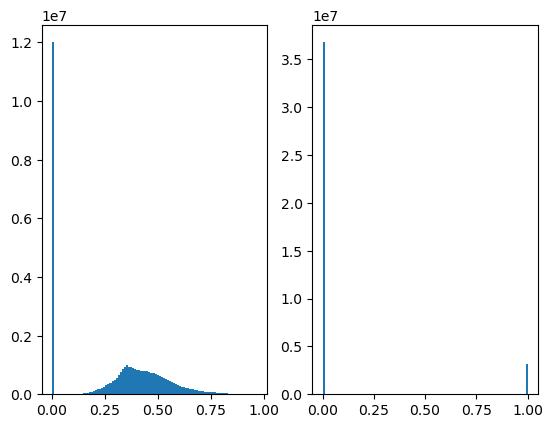

th: 0.1, fbeta: 0.13809054816028427
th: 0.15, fbeta: 0.13765662032606635
th: 0.2, fbeta: 0.1369723148576669
th: 0.25, fbeta: 0.13463476751772824
th: 0.3, fbeta: 0.13186264945251686
th: 0.35, fbeta: 0.13377871570984
th: 0.4, fbeta: 0.13540973894036093
th: 0.45, fbeta: 0.13004765598604948
th: 0.5, fbeta: 0.12115886425291346
	 epoch:10, avg train loss:0.6272, avg valid loss:0.6405, score:0.1381(th=0.1) ::: time:115.02s
	 === epoch: 11: training ===
	 Epoch: [11][0/31] Elapsed 0m 0s (remain 0m 12s) Loss: 0.6169(0.6169) 
	 Epoch: [11][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5563(0.6162) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5400(0.5400) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5950(0.6384) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


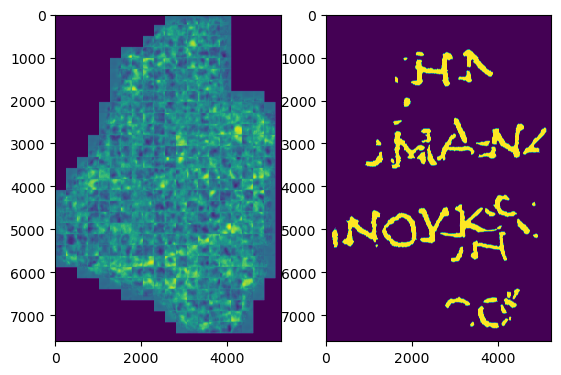

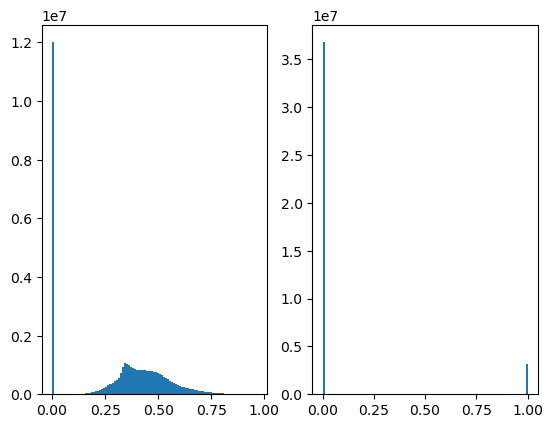

th: 0.1, fbeta: 0.1380858843311733
th: 0.15, fbeta: 0.13791583841589217
th: 0.2, fbeta: 0.13716691079793406
th: 0.25, fbeta: 0.13572638768419176
th: 0.3, fbeta: 0.1332444719065296
th: 0.35, fbeta: 0.13586475002984874
th: 0.4, fbeta: 0.13847678333032892
th: 0.45, fbeta: 0.1333913416584319
th: 0.5, fbeta: 0.12328131389241265
	 epoch:11, avg train loss:0.6162, avg valid loss:0.6384, score:0.1385(th=0.4) ::: time:126.28s
	 === epoch: 12: training ===
	 Epoch: [12][0/31] Elapsed 0m 0s (remain 0m 15s) Loss: 0.6278(0.6278) 
	 Epoch: [12][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6789(0.6161) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5509(0.5509) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6138(0.6388) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


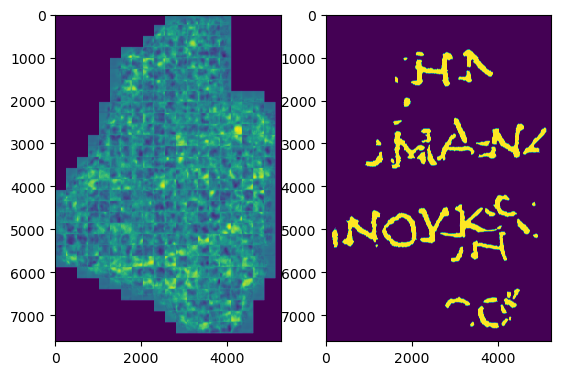

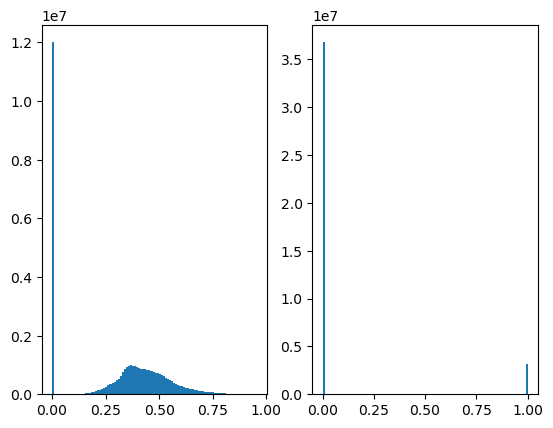

th: 0.1, fbeta: 0.13807870830935667
th: 0.15, fbeta: 0.1378117778713976
th: 0.2, fbeta: 0.13722085078704097
th: 0.25, fbeta: 0.13565070322543887
th: 0.3, fbeta: 0.1324385277760221
th: 0.35, fbeta: 0.131896882650959
th: 0.4, fbeta: 0.13371831965501021
th: 0.45, fbeta: 0.12878816931062456
th: 0.5, fbeta: 0.1212313416956225
	 epoch:12, avg train loss:0.6161, avg valid loss:0.6388, score:0.1381(th=0.1) ::: time:137.82s
	 === epoch: 13: training ===
	 Epoch: [13][0/31] Elapsed 0m 0s (remain 0m 12s) Loss: 0.6101(0.6101) 
	 Epoch: [13][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6746(0.6209) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5232(0.5232) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5937(0.6257) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


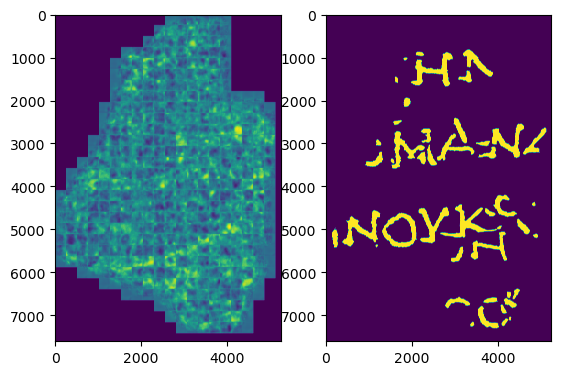

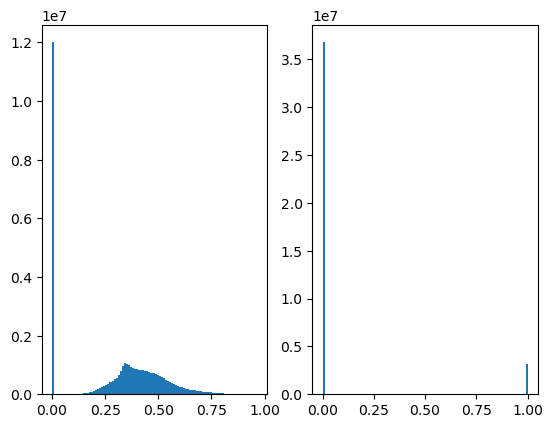

th: 0.1, fbeta: 0.13809933993533086
th: 0.15, fbeta: 0.13781775543601762
th: 0.2, fbeta: 0.13701382468656964
th: 0.25, fbeta: 0.1350129215746996
th: 0.3, fbeta: 0.13182202516707203
th: 0.35, fbeta: 0.13393476868306137
th: 0.4, fbeta: 0.13491830693719428
th: 0.45, fbeta: 0.12976409650509227
th: 0.5, fbeta: 0.120040473788168
	 epoch:13, avg train loss:0.6209, avg valid loss:0.6257, score:0.1381(th=0.1) ::: time:149.18s
	 === epoch: 14: training ===
	 Epoch: [14][0/31] Elapsed 0m 0s (remain 0m 13s) Loss: 0.5300(0.5300) 
	 Epoch: [14][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6182(0.6080) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5446(0.5446) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6109(0.6367) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


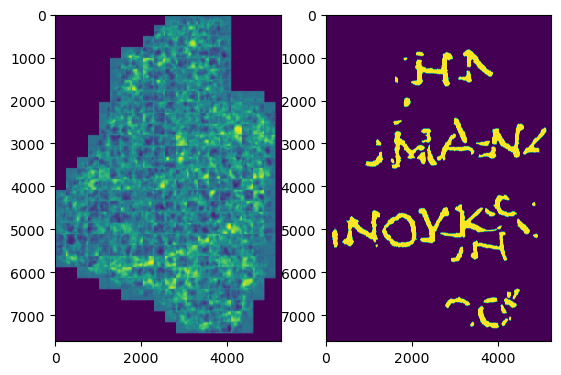

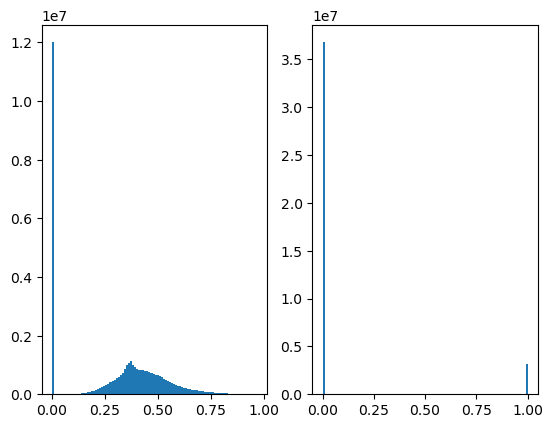

th: 0.1, fbeta: 0.1381214794269517
th: 0.15, fbeta: 0.1377541242667337
th: 0.2, fbeta: 0.13704257010062235
th: 0.25, fbeta: 0.13442171427282149
th: 0.3, fbeta: 0.13060977256702133
th: 0.35, fbeta: 0.1286654945875848
th: 0.4, fbeta: 0.13345096438546175
th: 0.45, fbeta: 0.12960022097780347
th: 0.5, fbeta: 0.12172165214520415
	 epoch:14, avg train loss:0.6080, avg valid loss:0.6367, score:0.1381(th=0.1) ::: time:160.82s
	 === epoch: 15: training ===
	 Epoch: [15][0/31] Elapsed 0m 0s (remain 0m 12s) Loss: 0.6074(0.6074) 
	 Epoch: [15][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.7266(0.6094) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5222(0.5222) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6182(0.6473) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


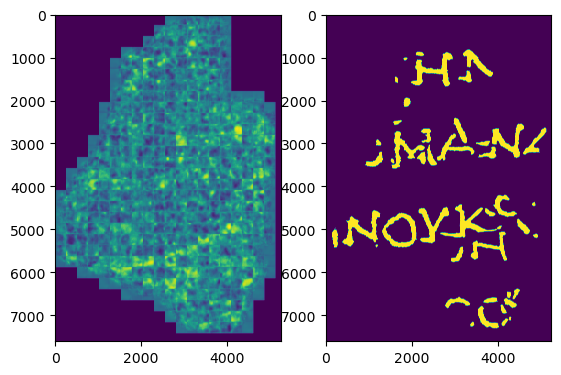

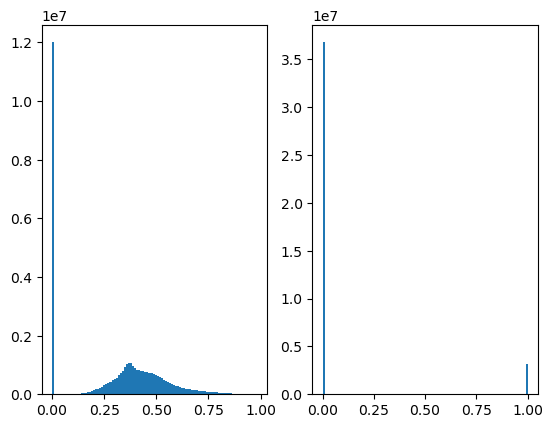

th: 0.1, fbeta: 0.13809272207918208
th: 0.15, fbeta: 0.13759975597171092
th: 0.2, fbeta: 0.1365643937674136
th: 0.25, fbeta: 0.13434750222728573
th: 0.3, fbeta: 0.1306426807804111
th: 0.35, fbeta: 0.1282994180197602
th: 0.4, fbeta: 0.13261386018372395
th: 0.45, fbeta: 0.12815648502768878
th: 0.5, fbeta: 0.12025685200602389
	 epoch:15, avg train loss:0.6094, avg valid loss:0.6473, score:0.1381(th=0.1) ::: time:172.31s
	 === epoch: 16: training ===
	 Epoch: [16][0/31] Elapsed 0m 0s (remain 0m 13s) Loss: 0.5707(0.5707) 
	 Epoch: [16][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6730(0.6105) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5497(0.5497) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6465(0.7036) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


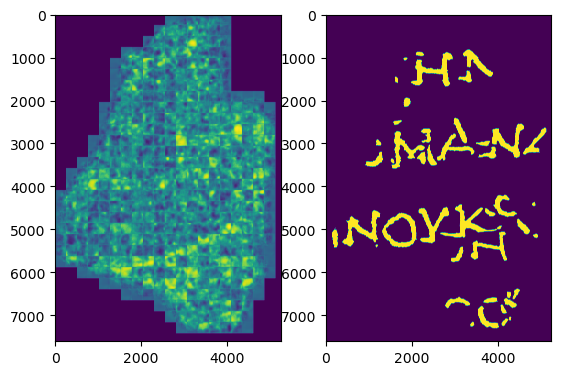

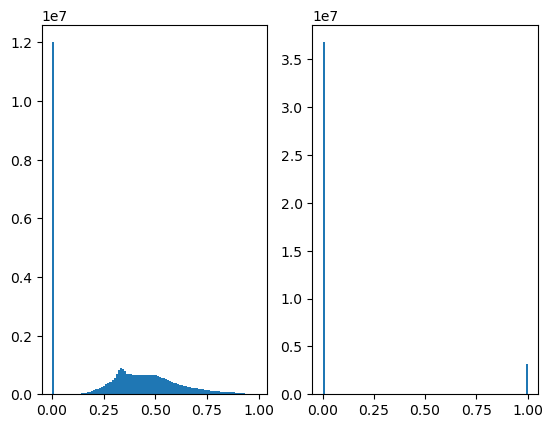

th: 0.1, fbeta: 0.13809450746363855
th: 0.15, fbeta: 0.1381031826288797
th: 0.2, fbeta: 0.13775624782427384
th: 0.25, fbeta: 0.13599544009451206
th: 0.3, fbeta: 0.1360017323850515
th: 0.35, fbeta: 0.14329406825870192
th: 0.4, fbeta: 0.14301697990244552
th: 0.45, fbeta: 0.13734960594390033
th: 0.5, fbeta: 0.1278135556816483
	 epoch:16, avg train loss:0.6105, avg valid loss:0.7036, score:0.1433(th=0.35) ::: time:183.65s
	 === epoch: 17: training ===
	 Epoch: [17][0/31] Elapsed 0m 0s (remain 0m 20s) Loss: 0.6482(0.6482) 
	 Epoch: [17][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.5504(0.6010) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.5071(0.5071) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6216(0.6431) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


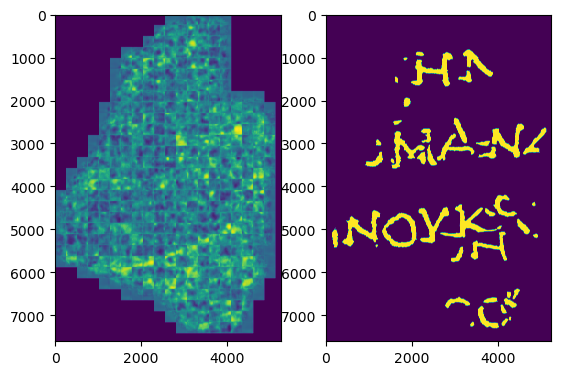

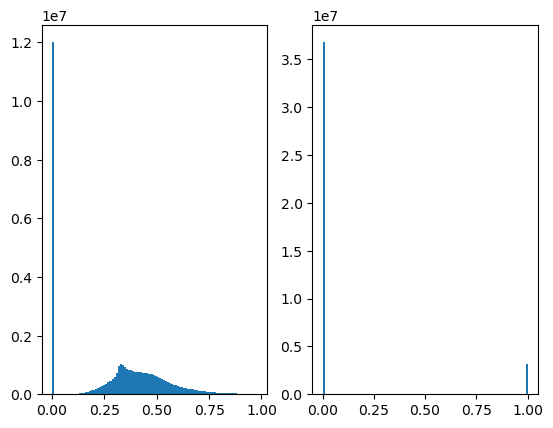

th: 0.1, fbeta: 0.1380425163347443
th: 0.15, fbeta: 0.13772111848926058
th: 0.2, fbeta: 0.13652813554992416
th: 0.25, fbeta: 0.13356684265098448
th: 0.3, fbeta: 0.1308160978083253
th: 0.35, fbeta: 0.13624924494900276
th: 0.4, fbeta: 0.1353929233152438
th: 0.45, fbeta: 0.1286486398697089
th: 0.5, fbeta: 0.11929237244065363
	 epoch:17, avg train loss:0.6010, avg valid loss:0.6431, score:0.1380(th=0.1) ::: time:195.25s
	 === epoch: 18: training ===
	 Epoch: [18][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.5686(0.5686) 
	 Epoch: [18][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5908(0.5858) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4707(0.4707) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5944(0.6122) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


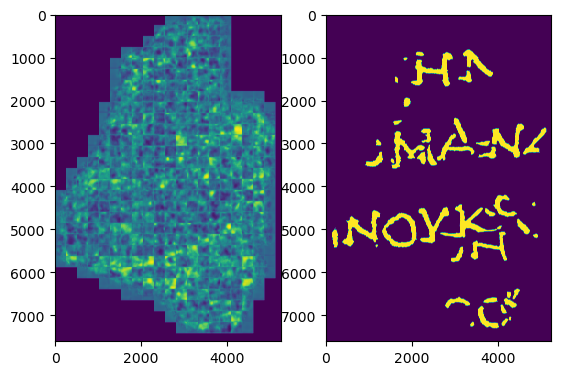

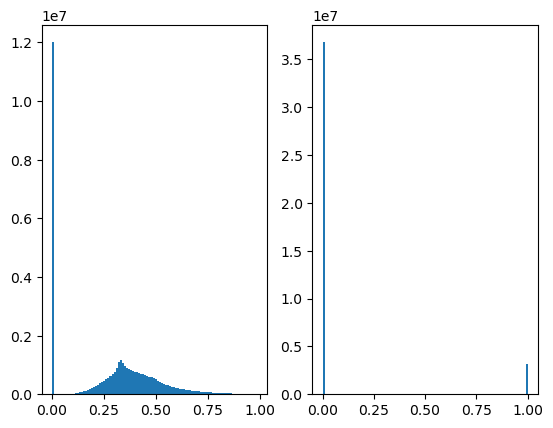

th: 0.1, fbeta: 0.13810763354186759
th: 0.15, fbeta: 0.13742952294668445
th: 0.2, fbeta: 0.13553977753083277
th: 0.25, fbeta: 0.1325372508291203
th: 0.3, fbeta: 0.12848050439583641
th: 0.35, fbeta: 0.13180254602580752
th: 0.4, fbeta: 0.130740817449411
th: 0.45, fbeta: 0.124521808176618
th: 0.5, fbeta: 0.1144897368910556
	 epoch:18, avg train loss:0.5858, avg valid loss:0.6122, score:0.1381(th=0.1) ::: time:206.66s
	 === epoch: 19: training ===
	 Epoch: [19][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.6047(0.6047) 
	 Epoch: [19][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5022(0.5815) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4949(0.4949) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6124(0.6329) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


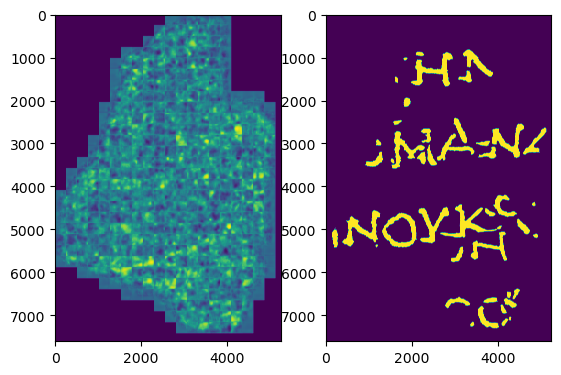

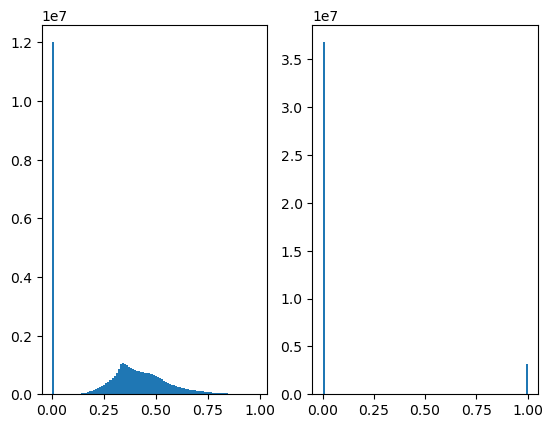

th: 0.1, fbeta: 0.13811798347876475
th: 0.15, fbeta: 0.138097758616061
th: 0.2, fbeta: 0.13750254886868019
th: 0.25, fbeta: 0.13582463070144496
th: 0.3, fbeta: 0.13389656697750188
th: 0.35, fbeta: 0.13828709824099855
th: 0.4, fbeta: 0.1387087243585368
th: 0.45, fbeta: 0.1293189361628393
th: 0.5, fbeta: 0.1183783938812561
	 epoch:19, avg train loss:0.5815, avg valid loss:0.6329, score:0.1387(th=0.4) ::: time:218.16s
	 === epoch: 20: training ===
	 Epoch: [20][0/31] Elapsed 0m 0s (remain 0m 22s) Loss: 0.6831(0.6831) 
	 Epoch: [20][30/31] Elapsed 0m 4s (remain 0m 0s) Loss: 0.6260(0.5800) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4885(0.4885) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6050(0.6259) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


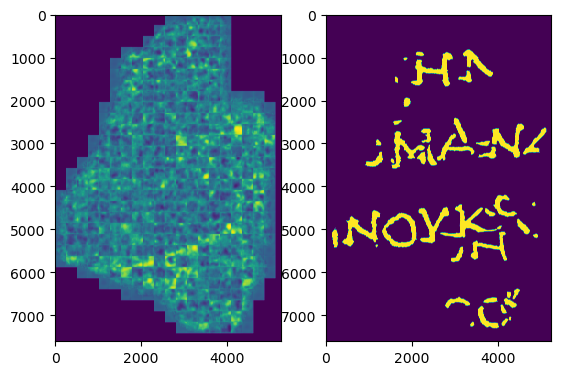

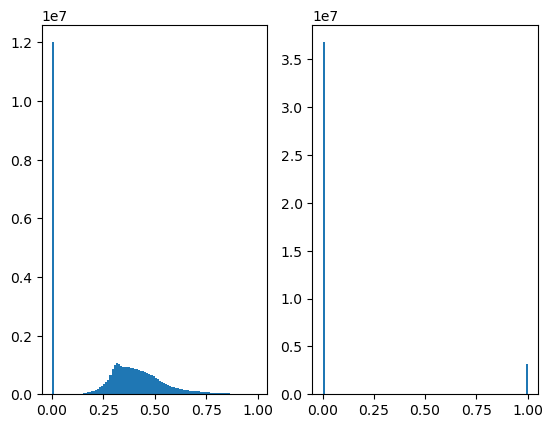

th: 0.1, fbeta: 0.1381022592270185
th: 0.15, fbeta: 0.13821623011680506
th: 0.2, fbeta: 0.13755380993542168
th: 0.25, fbeta: 0.13467112925820077
th: 0.3, fbeta: 0.13304407901951898
th: 0.35, fbeta: 0.1378307878472808
th: 0.4, fbeta: 0.13278089576299926
th: 0.45, fbeta: 0.12549538220663187
th: 0.5, fbeta: 0.11510101536789506
	 epoch:20, avg train loss:0.5800, avg valid loss:0.6259, score:0.1382(th=0.15) ::: time:230.07s
	 === epoch: 21: training ===
	 Epoch: [21][0/31] Elapsed 0m 0s (remain 0m 15s) Loss: 0.4986(0.4986) 
	 Epoch: [21][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5350(0.5489) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4947(0.4947) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6086(0.6365) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


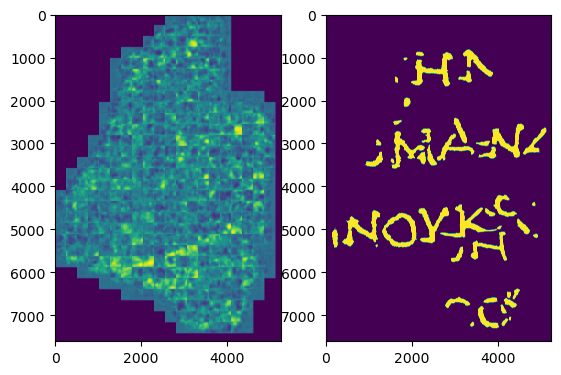

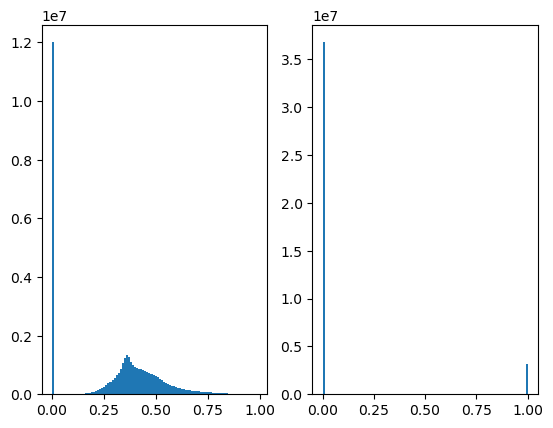

th: 0.1, fbeta: 0.13807551974008328
th: 0.15, fbeta: 0.13815707858450535
th: 0.2, fbeta: 0.1381756243080288
th: 0.25, fbeta: 0.1364970569239497
th: 0.3, fbeta: 0.1314759600024151
th: 0.35, fbeta: 0.1308618525087239
th: 0.4, fbeta: 0.1358189408233854
th: 0.45, fbeta: 0.12659863306505742
th: 0.5, fbeta: 0.11233343061109843
	 epoch:21, avg train loss:0.5489, avg valid loss:0.6365, score:0.1382(th=0.2) ::: time:241.30s
	 === epoch: 22: training ===
	 Epoch: [22][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.6203(0.6203) 
	 Epoch: [22][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.6532(0.5542) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4954(0.4954) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5726(0.6781) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


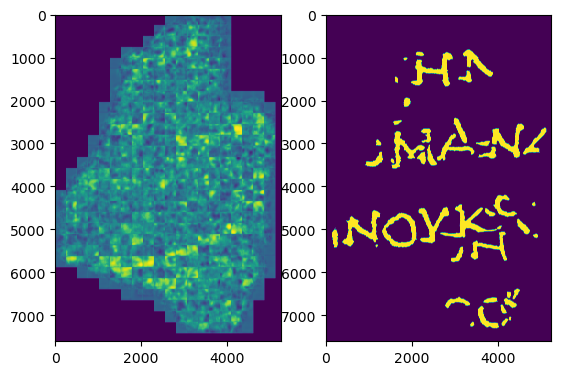

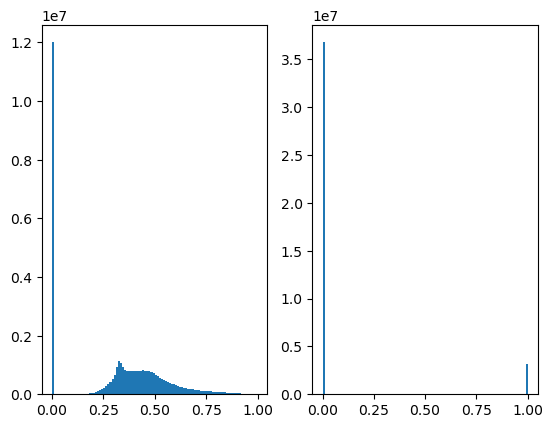

th: 0.1, fbeta: 0.13807969424670719
th: 0.15, fbeta: 0.13812036244606918
th: 0.2, fbeta: 0.13803573776564337
th: 0.25, fbeta: 0.13727488065016685
th: 0.3, fbeta: 0.13714687814448775
th: 0.35, fbeta: 0.14615493074949487
th: 0.4, fbeta: 0.1447668236510019
th: 0.45, fbeta: 0.1337835083668385
th: 0.5, fbeta: 0.11695704933576892
	 epoch:22, avg train loss:0.5542, avg valid loss:0.6781, score:0.1462(th=0.35) ::: time:252.70s
	 === epoch: 23: training ===
	 Epoch: [23][0/31] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5537(0.5537) 
	 Epoch: [23][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5272(0.5371) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4905(0.4905) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5931(0.6813) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


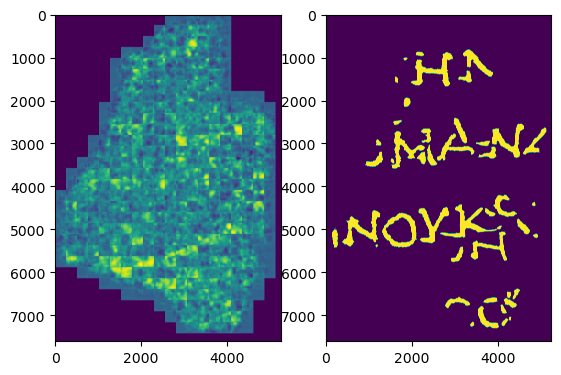

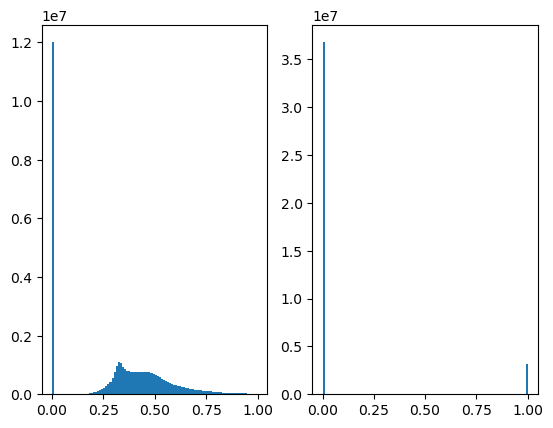

th: 0.1, fbeta: 0.1380838738155345
th: 0.15, fbeta: 0.13814214944162714
th: 0.2, fbeta: 0.13814733590130332
th: 0.25, fbeta: 0.13806004201068237
th: 0.3, fbeta: 0.13775590238629032
th: 0.35, fbeta: 0.14612766473730365
th: 0.4, fbeta: 0.1436338734342301
th: 0.45, fbeta: 0.1329017289522323
th: 0.5, fbeta: 0.1177397663872138
	 epoch:23, avg train loss:0.5371, avg valid loss:0.6813, score:0.1461(th=0.35) ::: time:264.04s
	 === epoch: 24: training ===
	 Epoch: [24][0/31] Elapsed 0m 0s (remain 0m 20s) Loss: 0.5305(0.5305) 
	 Epoch: [24][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4989(0.5213) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4906(0.4906) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5638(0.6283) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


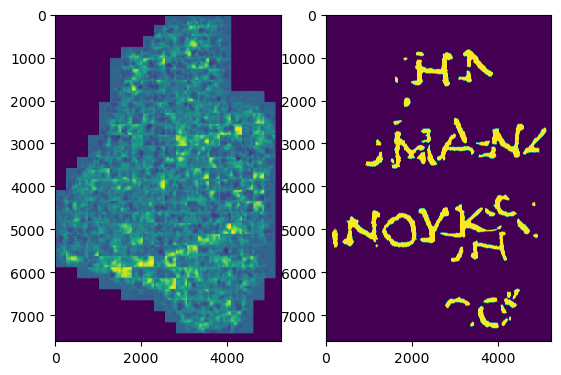

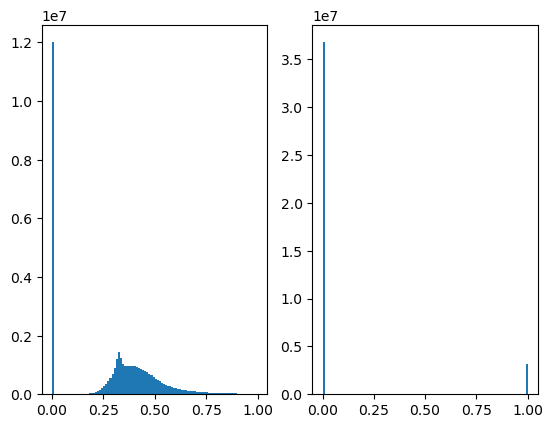

th: 0.1, fbeta: 0.13808087156739351
th: 0.15, fbeta: 0.13808707706317794
th: 0.2, fbeta: 0.13791124176236827
th: 0.25, fbeta: 0.13659499042262804
th: 0.3, fbeta: 0.13406643611501445
th: 0.35, fbeta: 0.14340846072336308
th: 0.4, fbeta: 0.14025568062000934
th: 0.45, fbeta: 0.12805497631089544
th: 0.5, fbeta: 0.10765231555405591
	 epoch:24, avg train loss:0.5213, avg valid loss:0.6283, score:0.1434(th=0.35) ::: time:275.44s
	 === epoch: 25: training ===
	 Epoch: [25][0/31] Elapsed 0m 0s (remain 0m 19s) Loss: 0.4946(0.4946) 
	 Epoch: [25][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4587(0.5182) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4757(0.4757) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5593(0.6196) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


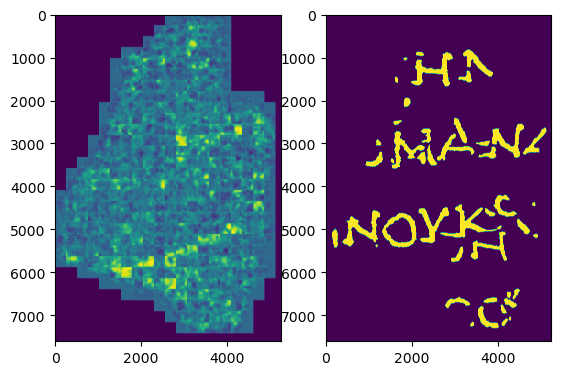

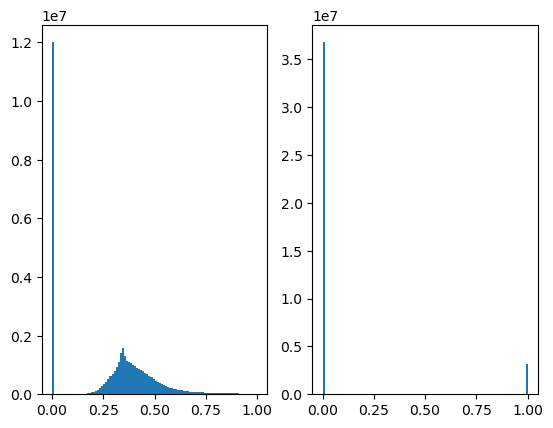

th: 0.1, fbeta: 0.13808396520133884
th: 0.15, fbeta: 0.13808785566406057
th: 0.2, fbeta: 0.1379629196923995
th: 0.25, fbeta: 0.13663026082016433
th: 0.3, fbeta: 0.13276312159336537
th: 0.35, fbeta: 0.13689317080106372
th: 0.4, fbeta: 0.13557941755207195
th: 0.45, fbeta: 0.12309742663311375
th: 0.5, fbeta: 0.10083115400176249
	 epoch:25, avg train loss:0.5182, avg valid loss:0.6196, score:0.1381(th=0.15) ::: time:286.92s
	 === epoch: 26: training ===
	 Epoch: [26][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.4635(0.4635) 
	 Epoch: [26][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5609(0.5128) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4567(0.4567) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5398(0.5909) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


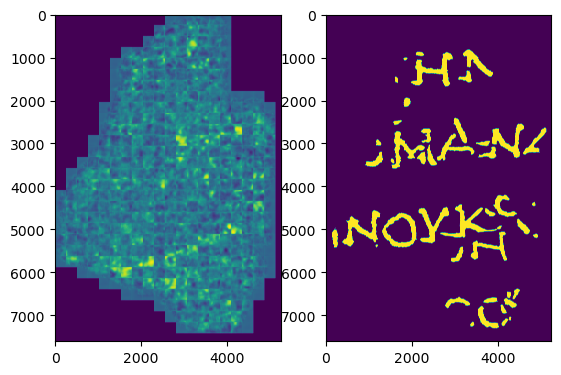

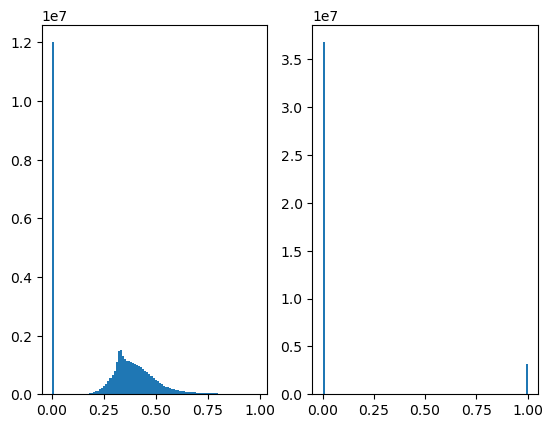

th: 0.1, fbeta: 0.13808558130712664
th: 0.15, fbeta: 0.13811822087186365
th: 0.2, fbeta: 0.13810945026125165
th: 0.25, fbeta: 0.1368184314259324
th: 0.3, fbeta: 0.13264917610202565
th: 0.35, fbeta: 0.1390211057173398
th: 0.4, fbeta: 0.13543133509749355
th: 0.45, fbeta: 0.12152066914151025
th: 0.5, fbeta: 0.09880510103256203
	 epoch:26, avg train loss:0.5128, avg valid loss:0.5909, score:0.1390(th=0.35) ::: time:298.14s
	 === epoch: 27: training ===
	 Epoch: [27][0/31] Elapsed 0m 0s (remain 0m 13s) Loss: 0.5257(0.5257) 
	 Epoch: [27][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5405(0.4997) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4704(0.4704) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5363(0.6018) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


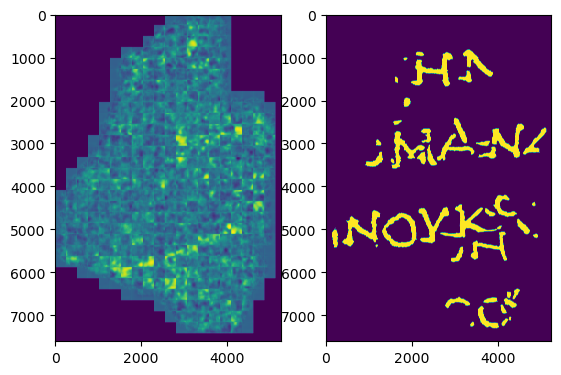

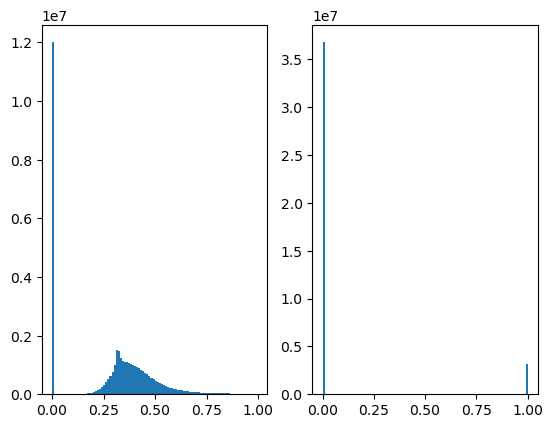

th: 0.1, fbeta: 0.13808442213217523
th: 0.15, fbeta: 0.13808782690044216
th: 0.2, fbeta: 0.13811374629474632
th: 0.25, fbeta: 0.13636367619637946
th: 0.3, fbeta: 0.13261159271948345
th: 0.35, fbeta: 0.14098164196627036
th: 0.4, fbeta: 0.1380536010957021
th: 0.45, fbeta: 0.12386174339862674
th: 0.5, fbeta: 0.1025736184810304
	 epoch:27, avg train loss:0.4997, avg valid loss:0.6018, score:0.1410(th=0.35) ::: time:309.39s
	 === epoch: 28: training ===
	 Epoch: [28][0/31] Elapsed 0m 0s (remain 0m 15s) Loss: 0.5421(0.5421) 
	 Epoch: [28][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5567(0.5053) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4487(0.4487) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5360(0.5887) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


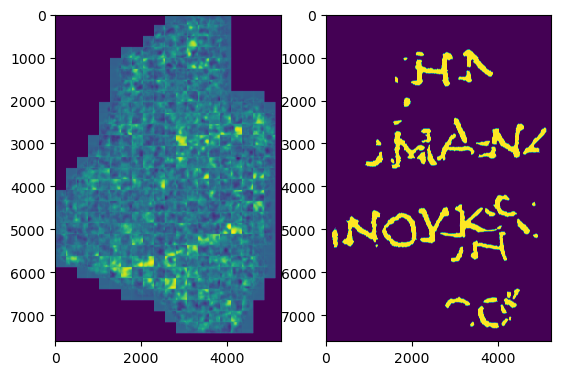

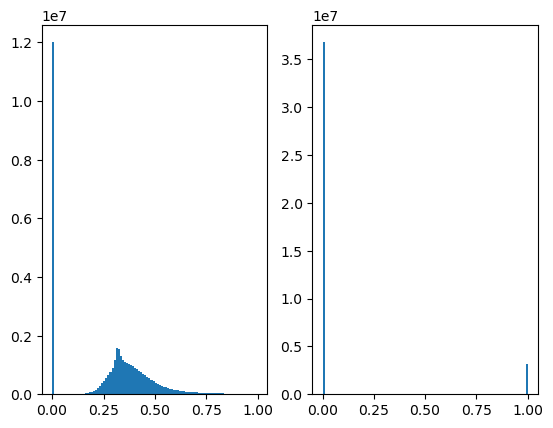

th: 0.1, fbeta: 0.1380842345496765
th: 0.15, fbeta: 0.13799600983049226
th: 0.2, fbeta: 0.13778650138060855
th: 0.25, fbeta: 0.13493779737604922
th: 0.3, fbeta: 0.13045517295881656
th: 0.35, fbeta: 0.13785458958367217
th: 0.4, fbeta: 0.13085647587807137
th: 0.45, fbeta: 0.11482712460711673
th: 0.5, fbeta: 0.09499169287309883
	 epoch:28, avg train loss:0.5053, avg valid loss:0.5887, score:0.1381(th=0.1) ::: time:321.02s
	 === epoch: 29: training ===
	 Epoch: [29][0/31] Elapsed 0m 0s (remain 0m 20s) Loss: 0.4684(0.4684) 
	 Epoch: [29][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5290(0.4901) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4730(0.4730) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5630(0.6230) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


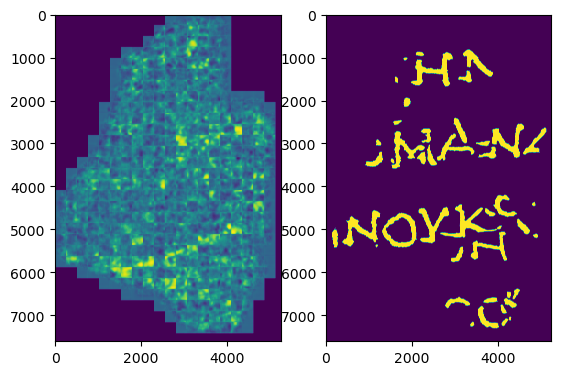

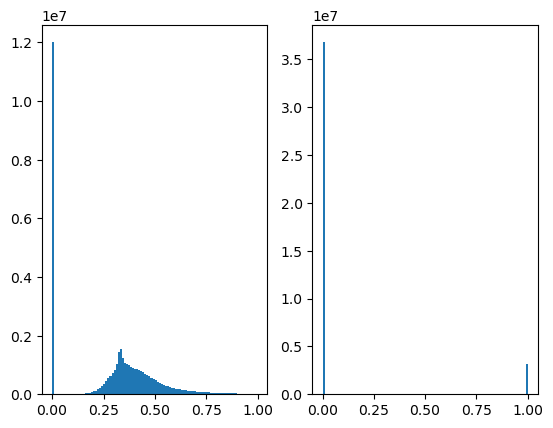

th: 0.1, fbeta: 0.1380824645655505
th: 0.15, fbeta: 0.1380728168208397
th: 0.2, fbeta: 0.1379406386317182
th: 0.25, fbeta: 0.13616258352265184
th: 0.3, fbeta: 0.13278989729562937
th: 0.35, fbeta: 0.1394756241773289
th: 0.4, fbeta: 0.13336265215177223
th: 0.45, fbeta: 0.12029640995996105
th: 0.5, fbeta: 0.1031360133954368
	 epoch:29, avg train loss:0.4901, avg valid loss:0.6230, score:0.1395(th=0.35) ::: time:332.47s
	 === epoch: 30: training ===
	 Epoch: [30][0/31] Elapsed 0m 0s (remain 0m 14s) Loss: 0.4166(0.4166) 
	 Epoch: [30][30/31] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4969(0.4943) 
	 EVAL: [0/27] Elapsed 0m 0s (remain 0m 4s) Loss: 0.4675(0.4675) 
	 EVAL: [26/27] Elapsed 0m 3s (remain 0m 0s) Loss: 0.5437(0.6145) 
valid_preds shape =  (7606, 5249, 1)
valid_targets shape =  (7606, 5249, 1)


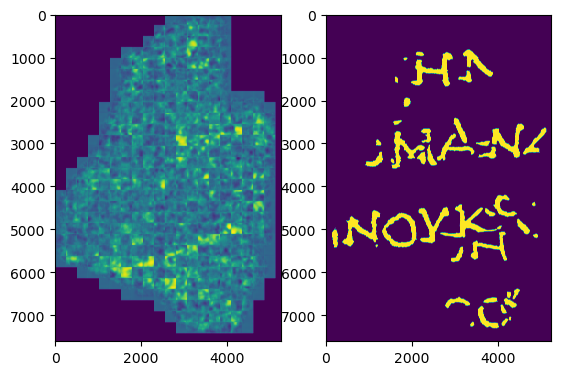

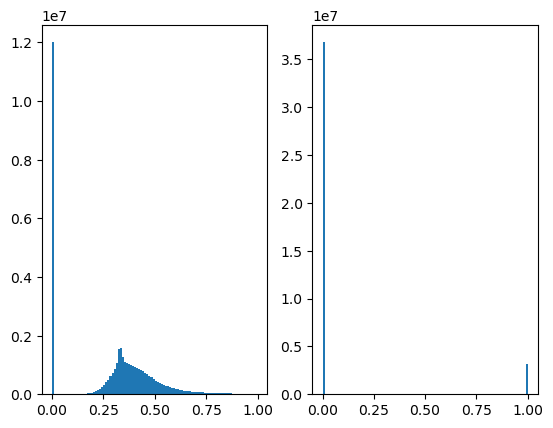

th: 0.1, fbeta: 0.13808070424590954
th: 0.15, fbeta: 0.1380978317876736
th: 0.2, fbeta: 0.13796237267680592
th: 0.25, fbeta: 0.13644396908916773
th: 0.3, fbeta: 0.1333094080777885
th: 0.35, fbeta: 0.1406839900699035
th: 0.4, fbeta: 0.13550220047320352
th: 0.45, fbeta: 0.12201238979836254
th: 0.5, fbeta: 0.10594429114954176
	 epoch:30, avg train loss:0.4943, avg valid loss:0.6145, score:0.1407(th=0.35) ::: time:343.81s


In [19]:
training_loop(CFG)
# if not CFG["DEBUG"]:
#     wandb.finish()